In [19]:
import warnings
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from rdkit import *
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split 

In [5]:
warnings.filterwarnings("ignore")
#Read the data
hiv = pd.read_csv('./HIV.csv')
hiv.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


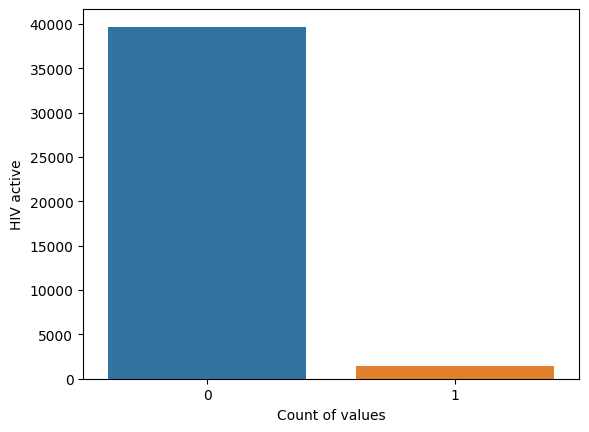

In [8]:
#Let's look at the target values count

sns.countplot(data = hiv, x='HIV_active', orient='v')
plt.ylabel('HIV active')
plt.xlabel('Count of values')
plt.show()

In [11]:
#Transform SMILES to MOL
hiv['mol'] = hiv['smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

[12:11:22] WARNING: not removing hydrogen atom without neighbors
[12:11:22] WARNING: not removing hydrogen atom without neighbors


In [15]:
#Extract descriptors
hiv['tpsa'] = hiv['mol'].apply(lambda x: Descriptors.TPSA(x))
hiv['mol_w'] = hiv['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
hiv['num_valence_electrons'] = hiv['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
hiv['num_heteroatoms'] = hiv['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [17]:
y = hiv.HIV_active.values
X = hiv.drop(columns=['smiles', 'activity','HIV_active', 'mol'])

In [20]:
#Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)

In [21]:
from sklearn.metrics import auc, roc_curve

def evaluation_class(model, X_test, y_test):
    prediction = model.predict_proba(X_test)
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score:', round(roc_auc, 4))

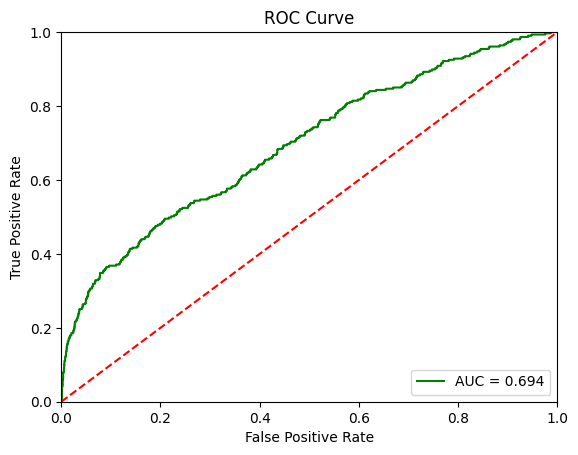

ROC AUC score: 0.6944


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

evaluation_class(lr, X_test, y_test)

### Adding molecular embeddings with mol2vec

In [34]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./model_300dim.pkl')

In [27]:
#Constructing sentences
hiv['sentence'] = hiv.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

In [35]:
#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

hiv['mol2vec'] = [DfVec(x) for x in sentences2vec(hiv['sentence'], model, unseen='UNK')]
X_mol = np.array([x.vec for x in hiv['mol2vec']])
X_mol = pd.DataFrame(X_mol)

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [ ]:
#Concatenating matrices of features
new_hiv = pd.concat((X, X_mol), axis=1)

X_train, X_test, y_train, y_test = train_test_split(new_hiv, y, test_size=.20, random_state=1)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)


evaluation_class(lr, X_test, y_test)

In [31]:
from gensim.models import KeyedVectors
import numpy as np

# Load your Gensim model (assumes you already have one trained)
model = KeyedVectors.load("./model_300dim.pkl")

# Tokenize and preprocess your sentences
sentences = ["This is a sample sentence.", "Another example sentence."]
tokenized_sentences = [sentence.split() for sentence in sentences]

# Calculate sentence embeddings by averaging word vectors
def sentence_embedding(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv.key_to_index]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate embeddings for each sentence
sentence_embeddings = [sentence_embedding(sentence, model) for sentence in tokenized_sentences]

# Now you can use sentence_embeddings for your downstream tasks


In [46]:
import gensim
print(gensim.__version__)

4.3.2


In [ ]:
#https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec